# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Reusable Function

In [2]:
def report_results(y_test, y_pred, model_name):
  # Accuracy Score
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{model_name} Accuracy Score: {accuracy}")

  # Precision, Recall, F1 Score
  print(classification_report(y_test, y_pred))

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f"{model_name} Confusion Matrix")
  plt.show()

# Load Dataset


In [3]:
df = pd.read_csv('Datasets/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Preprocessing

In [4]:
X = df.drop(columns = ['Outcome', 'Pregnancies'])
y = df['Outcome']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,84,0,0,0,0.0,0.304,21
618,112,82,24,0,28.2,1.282,50
346,139,46,19,83,28.7,0.654,22
294,161,50,0,0,21.9,0.254,65
231,134,80,37,370,46.2,0.238,46


In [8]:
num_features = X.select_dtypes(exclude='object').columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()
print(f"Numerical Features: {num_features}")
print(f"Categorical Features: {cat_features}")

Numerical Features: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical Features: []


#### 1) Handling Missing Values

In [9]:
print(f"X_train Missing Values %:\n {X_train.isnull().sum()/len(X_train) * 100}")
print(f"X_test Missing Values %:\n {X_test.isnull().sum()/len(X_test) * 100}")

X_train Missing Values %:
 Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
dtype: float64
X_test Missing Values %:
 Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
dtype: float64


#### 2) Dealing with categorical features
Encoding either with:


*   **LabelEncoder:** if categorical feature is ordinal
*   **OneHotEncoder:** if categorical feature is nominal




#### 3) Feature Scaling
Numerical Features are scaled with:


*   **StandardScaler:** if the feature follows a Normal Distribution
*   **MinMaxScaler:** otherwise



In [10]:
from scipy.stats import shapiro

gaussian_features = []
non_gaussian_features = []
for col in num_features:
  stat, p = shapiro(X_train[col])
  if p > 0.05:
    gaussian_features.append(col)
  else:
    non_gaussian_features.append(col)

print(f"Gaussian Features: {gaussian_features}")
print(f"Non-Gaussian Features: {non_gaussian_features}")

if len(gaussian_features) > 0:
  standard_scaler = StandardScaler()
if len(non_gaussian_features) > 0:
  min_max_scaler = MinMaxScaler()

Gaussian Features: []
Non-Gaussian Features: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


#### 4) Feature Engineering - Data Transformation
Numerical Features are transormed with:


*   **Log Transformation** if the feature is skewed (skewness>1)
*   **Polynomial Features** if low skewness and non-linear relationship

In [11]:
from scipy.stats import skew

skewed_features = [col for col in num_features if abs(skew(X_train[col])) > 1]
non_skewed_features = [col for col in num_features if col not in skewed_features]

print(f"Skewed Features: {skewed_features}")
print(f"Non-Skewed Features: {non_skewed_features}")

if len(skewed_features) > 0:
  log_transformer = FunctionTransformer(np.log1p, validate=False)
if len(non_skewed_features) > 0:
  poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

Skewed Features: ['BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
Non-Skewed Features: ['Glucose', 'SkinThickness', 'BMI']


# Prepare the Preprocessor

In [12]:
# We choose to apply polynomial transformer to non_skewed_features
# and min_max_scaler to non_gaussian_features

preprocessor = ColumnTransformer([
    ('poly_transformer', poly_transformer, non_skewed_features),
    ('min_max_scaler', min_max_scaler, non_gaussian_features),
], remainder = 'passthrough')

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Model Training

In [25]:
# Pipeline with preprocessor and LogisticRegression model
model = LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

# Fit the model
model.fit(X_train_preprocessed, y_train)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

# Predictions

In [26]:
# Predict Outcomes
y_pred = model.predict(X_test_preprocessed)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


# Model Evaluation

Naive Model Accuracy Score: 0.7857142857142857
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        99
           1       0.73      0.64      0.68        55

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



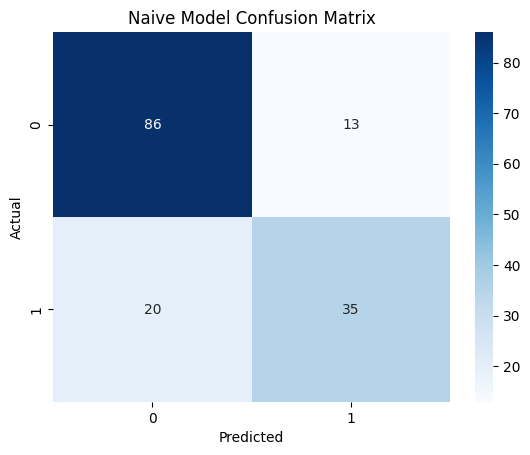

In [27]:
# predefined function
report_results(y_test, y_pred, 'Naive Model')

# Improving Logistic Regression

The following methods could be used to tune Logistic Regression for better performance
1.   **Regularization:** Lasso (L1) and Ridge (L2)
2.   **Handling Class Imbalance**
3.   **Feature Engineering:** Feature Selection
4.   **Polynomial Regression:** Adding Polynomial Features





#### L1 (Lasso) Regression
Shrinks some feature weights to **zero**, performing **feature selection**



In [28]:
lasso_model = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', cv=5, random_state=42, max_iter=1000)

lasso_model.fit(X_train_preprocessed, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, penalty='l1', random_state=42,
                     solver='liblinear')

In [29]:
lasso_y_pred = lasso_model.predict(X_test_preprocessed)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': lasso_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### L2 (Ridge) Regression
Penalizes large weights but keeps all features

In [43]:
ridge_model = LogisticRegressionCV(Cs=10, penalty='l2', solver='sag', cv=5, random_state=42, max_iter=10000)

ridge_model.fit(X_train_preprocessed, y_train)

LogisticRegressionCV(cv=5, max_iter=10000, random_state=42, solver='sag')

In [44]:
ridge_y_pred = ridge_model.predict(X_test_preprocessed)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': ridge_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Handling Class Imbalance

In [32]:
balanced_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

balanced_model.fit(X_train_preprocessed, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [33]:
balanced_y_pred = ridge_model.predict(X_test_preprocessed)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': balanced_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Feature Selection

In [34]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(Lasso(alpha=0.1), threshold="mean")

selector.fit(X_train_preprocessed, y_train)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

selected_features_mask = selector.get_support()

# Get the column names from the preprocessor pipeline
# Assuming preprocessor is your ColumnTransformer object
# Replace with the actual name of your preprocessor variable
preprocessor_columns = preprocessor.get_feature_names_out()

# Get the names of the selected features
selected_feature_names = [feature for feature, selected in zip(preprocessor_columns, selected_features_mask) if selected]

print(selected_features_mask)
tmp = pd.DataFrame(X_train_selected, columns=selected_feature_names)
tmp.head()

[ True False False False False False  True  True  True False False False
 False False False False]


,poly_transformer__Glucose,poly_transformer__SkinThickness^2,poly_transformer__SkinThickness BMI,poly_transformer__BMI^2
0,84.0,0.0,0.0,0.00
1,112.0,576.0,676.8,795.24
2,139.0,361.0,545.3,823.69
3,161.0,0.0,0.0,479.61
4,134.0,1369.0,1709.4,2134.44


In [35]:
selector_model = LogisticRegression(random_state=42)

selector_model.fit(X_train_selected, y_train)

LogisticRegression(random_state=42)

In [36]:
selector_y_pred = selector_model.predict(X_test_selected)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': selector_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Polynomial Regression
Already added PolynomialFeatures to the preprocessor

# Imporved Models Evaluation

Lasso Model Accuracy Score: 0.7727272727272727
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



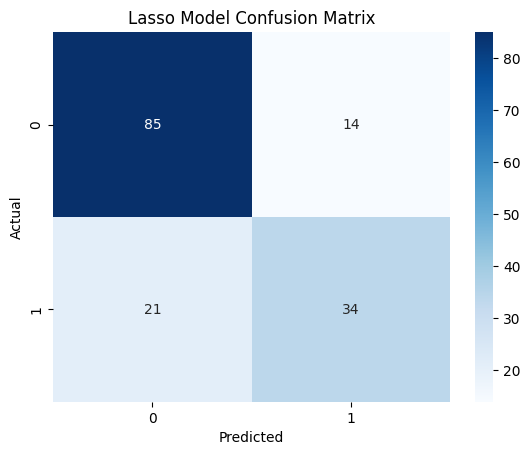

Ridge Model Accuracy Score: 0.7597402597402597
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        99
           1       0.74      0.51      0.60        55

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.72       154
weighted avg       0.76      0.76      0.75       154



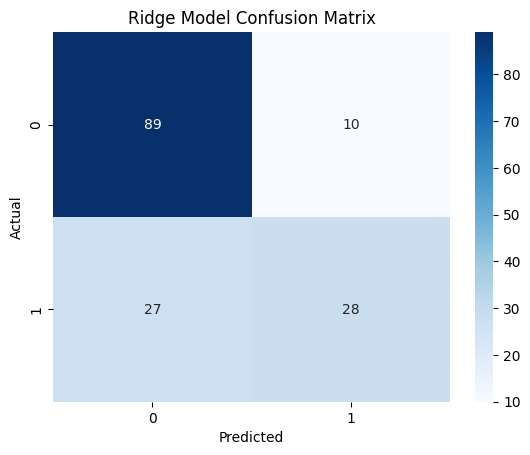

Balanced Model Accuracy Score: 0.7597402597402597
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        99
           1       0.74      0.51      0.60        55

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.72       154
weighted avg       0.76      0.76      0.75       154



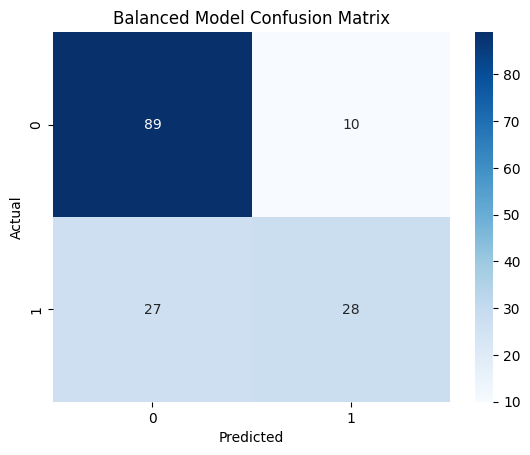

Feature Selection Model Accuracy Score: 0.7597402597402597
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.69      0.60      0.64        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



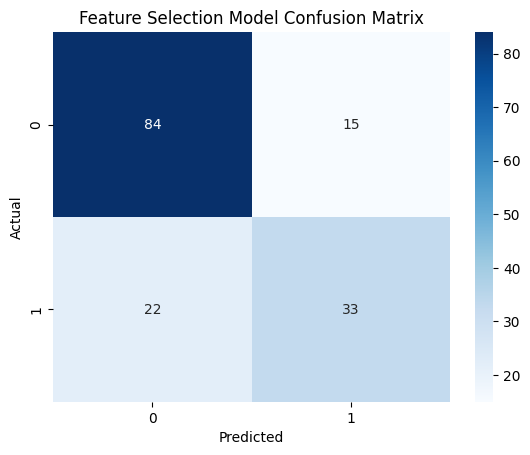

In [45]:
# Lasso Model Results
report_results(y_test, lasso_y_pred, "Lasso Model")
# Ridge Model Results
report_results(y_test, ridge_y_pred, "Ridge Model")
# Balanced Model Results
report_results(y_test, balanced_y_pred, "Balanced Model")
# Feature Selection Model Results
report_results(y_test, selector_y_pred, "Feature Selection Model")